In [1]:
import torch
import numpy as np
# import wandb
from models.lightning_models import Unet3D
from modules.segmentation_model import Unet, PositionalUnet
from loaders.lazy_loaders import PatchDataloader
from monai.losses.dice import DiceLoss
from monai.losses.hausdorff_loss import HausdorffDTLoss
from monai.losses.focal_loss import FocalLoss
from monai.metrics import DiceMetric, compute_hausdorff_distance
from monai.transforms import (
    Compose,
    RandShiftIntensityd,
    RandAffined,
    RandZoomd,
    RandRotated
)
# from losses.jaccard_loss import JaccardLoss # TODO for later
from torch.nn import BCELoss
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import sigmoid
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.trainer import Trainer
# from losses.dice_loss import DiceLoss

channel_list = [1]
# slices = 80

train = np.load("../MAMAMIA_Challenge/train_ids_v_pojeb.npy", allow_pickle=True)[0:10]
validation = np.load("../MAMAMIA_Challenge/validation_ids_v_pojeb.npy", allow_pickle=True)[0:10]
sets = [train, validation]

# get zipped filepaths depending on channel count
channel_images = [None] * len(sets)
for i, set in enumerate(sets):
    set_images = [None] * len(channel_list)
    for j, channel in enumerate(channel_list):
        collected_channel_list = []
        for set_id in set:
            set_channel = next(set_id.glob(f"*000{channel}.nii.gz"))
            collected_channel_list.append(set_channel)

        set_images[j] = collected_channel_list

    channel_images[i] = set_images

# get labels
labels = [None] * len(sets)
for i, set in enumerate(sets):
    set_labels = []
    for id in set:
        seg = next(id.glob("*segmentation.nii.gz"))
        set_labels.append(seg)
    labels[i] = set_labels

# get dicts
train_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(list(zip(*channel_images[0])), labels[0])
]
val_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(list(zip(*channel_images[1])), labels[1])
]

patch_size = (128, 128, 128)
train_dataset = PatchDataloader(images_labels_dict=train_dicts, repeat=1, patch_size=patch_size)
validation_dataset = PatchDataloader(images_labels_dict=val_dicts, repeat=1, patch_size=-1)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=1)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=1)

# losses
haus = HausdorffDTLoss(include_background=False, sigmoid=True)
dice = DiceLoss(sigmoid=True)

combined_loss = lambda predicted, label: 0.5*(haus(predicted, label) + dice(predicted, label)) 

# metrics
dice_metric = DiceMetric(include_background=False)
def tresholded_dice(predicted, label, threshold=0.5):
    predicted = sigmoid(predicted) > threshold
    return dice_metric(predicted, label)

def tresholded_haus(predicted, label, threshold=0.5):
    predicted = sigmoid(predicted) > threshold
    return compute_hausdorff_distance(predicted, label, include_background=False)

focal = FocalLoss()
dice_focal_loss = lambda predicted, label: dice(predicted, label) + focal(predicted, label)


checkpoint_path = 'sample_code_submission/best-checkpoint-epoch=131-val_thresholded_dice=0.59.ckpt'
device = torch.device(0)
stride = (64, 64, 64)
model = Unet3D.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model=Unet,
    depths=[3, 3, 3, 9, 3],
    channel_multipliers=[1, 2, 4, 8, 16],
    embed_dim=64,
    patch_size=patch_size,
    strides=stride,
    loss=None,
    padding="same",
    classes=1,
    beta=1,
    initial_LR=1e-4,
    monai=True,
    # metrics=[('thresholded_dice', tresholded_dice), ('tresholded_haus', tresholded_haus)],
    # final_activation=torch.nn.Sigmoid(),
    # optimizer=AdamW
).to(device)
model.eval();


2025-07-11 10:52:57.983390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 10:52:57.995031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752223978.008114 1339300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752223978.011802 1339300 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752223978.021936 1339300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

prediction took 6.24 seconds


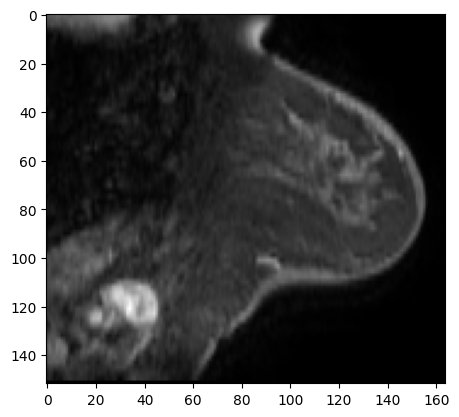

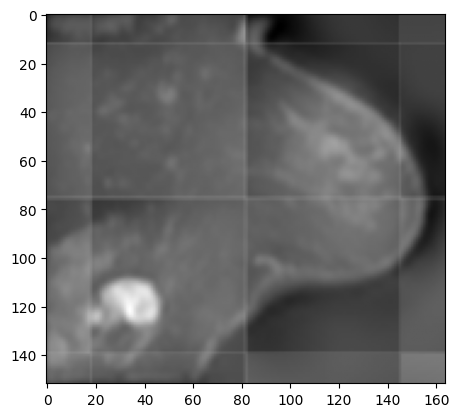

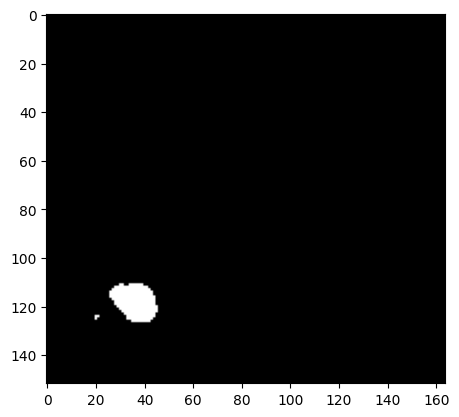

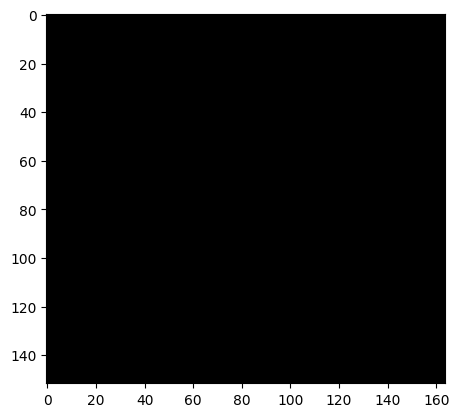

In [15]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

with torch.no_grad():
    for i, val_data in enumerate(validation_loader):
        if i > 0:
            break
        
        val_data[0] = val_data[0].to(device)
        val_data[1] = val_data[1].to(device)
        # model.validation_step(val_data, i)
        # image, label = val_data
        out = model.predict_step(
            val_data[0],
            patch_size=patch_size,
            strides=stride,
            padding="same", unpad=True, verbose=True
        )
        
        out = out[0,...]
        
        slice = 65
        plt.imshow(val_data[0].cpu().detach()[0, 0, :,:,slice], cmap='gray')
        plt.show()
        plt.imshow(out.cpu().detach()[:, :, slice], cmap='gray')
        plt.show()
        out = torch.sigmoid(out)
        # plt.imshow(out.cpu().detach()[:, :, slice], cmap='gray')
        # plt.show()
        out = out > 0.5
        # sitk.WriteImage(sitk.GetImageFromArray(out.cpu().detach()[0, ...]), '')
        plt.imshow(out.cpu().detach()[:, :, slice], cmap='gray')
        plt.show()
        plt.imshow(val_data[1].cpu().detach()[0,:,:,slice], cmap='gray')
        plt.show()

prediction took 10.75 seconds
torch.Size([1, 174, 264, 157])


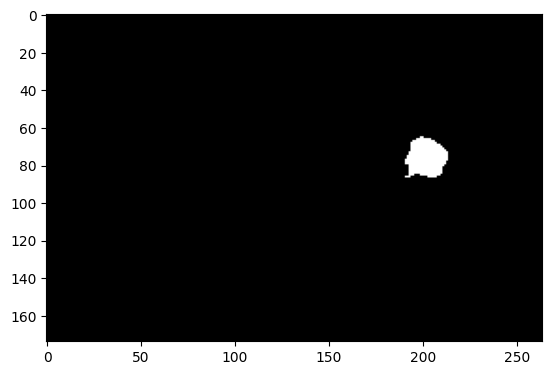

In [36]:
path = train[0] / (train[0].stem + "_0001.nii.gz")
img = sitk.ReadImage(path)

with torch.no_grad():
    data = torch.tensor(sitk.GetArrayFromImage(img), dtype=torch.float).to(device)[
        None, ...
    ]
    data = data.transpose(1, 3)
    out = model.predict_step(
        data,
        patch_size=patch_size,
        strides=stride,
        padding="same",
        unpad=True,
        verbose=True,
    )
    out = sigmoid(out) > 0.5
    print(out.shape)
    out = out[0, ...]
    plt.imshow(out.cpu().detach()[:, :, slice], cmap="gray")
    plt.show()

In [47]:
with torch.no_grad():
    data = torch.rand([1, 1, 10, 10, 10]).to(device)
    out = model.predict_step(
        data,
        patch_size=patch_size,
        strides=stride,
        padding="same",
        unpad=True,
        verbose=True,
    )
    # out = sigmoid(out) > 0.5
    print(out.shape)

prediction took 0.01 seconds
torch.Size([1, 10, 10, 10])


(157, 264, 174)


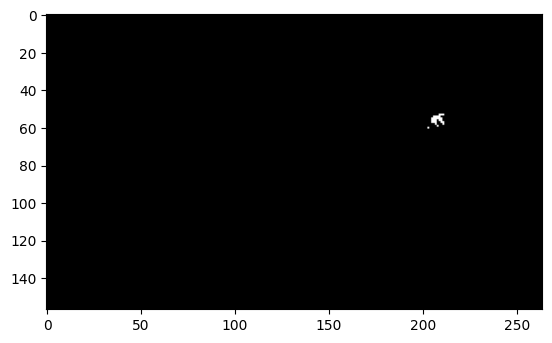

In [35]:
path_seg = '/home/romanuccio/RomanuccioDiff/MAMAMIA_Challenge/cropped_by_json_resampled_v2/ISPY2_120422/ISPY2_120422_segmentation.nii.gz'
lab = sitk.ReadImage(path_seg)
lab = sitk.GetArrayFromImage(lab)
print(lab.shape)
plt.imshow(lab[:, :, slice], cmap='gray')
plt.show()